In [84]:
%matplotlib inline

%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np

import xarray as xr

import regionmask

import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import cartopy.feature as cfeat
from scipy.interpolate import RectBivariateSpline

import glob

import sys
sys.path.append('../')
import grid_model as gridmod

np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

## GEOS Chem Runs

Using egrid, NEI, and our model emissions inventories for NO, NO2, SO2

In [177]:
ds_egrid_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation-egrid/temp_output/GEOSChem.SpeciesConc.20160*.nc4',combine='by_coords')
ds_egrid_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation-egrid/temp_output/GEOSChem.AerosolMass.20160*.nc4',combine='by_coords')
ds_egrid = xr.merge([ds_egrid_aerosolmass, ds_egrid_speciesconc])
ds_egrid.attrs['name'] = 'egrid'

ds_NEI_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gtropchem/merra2_05x0625_tropchem_na/OutputDir/GEOSChem.SpeciesConc.20160*.nc4',combine='by_coords')
ds_NEI_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gtropchem/merra2_05x0625_tropchem_na/OutputDir/GEOSChem.AerosolMass.20160*.nc4',combine='by_coords')
ds_NEI = xr.merge([ds_NEI_aerosolmass, ds_NEI_speciesconc])
ds_NEI.attrs['name'] = 'NEI'

ds_MODEL_speciesconc = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/temp_output/GEOSChem.SpeciesConc.20160*_0000z.nc4',combine='by_coords')
ds_MODEL_aerosolmass = xr.open_mfdataset('../../GCrundirs/type_NA-out_conc-yr_2016-gridmod_final-validation/temp_output/GEOSChem.AerosolMass.20160*_0000z.nc4',combine='by_coords')
ds_MODEL = xr.merge([ds_MODEL_aerosolmass, ds_MODEL_speciesconc])
ds_MODEL.attrs['name'] = 'MODEL'

datasets = [
    ds_NEI,
    ds_egrid,
    ds_MODEL
]

KeyboardInterrupt: 

In [3]:
######### calculate NOx in our datasets #######
for d in datasets:
    d['SpeciesConc_NOx'] = (
        d['SpeciesConc_NO'] + d['SpeciesConc_NO2'] #sum our NO2 and NO to get NOx
                    ) 

######### put into one dataset and convert to ppbv ###########
ds=xr.Dataset() #create an empty dataset
conc_species = [ #create a list of the species we got from our species conc
    'NO',
    'NO2',
    'NOx',
    'SO2',
    'O3'
]

for d in datasets:
    for s in conc_species: #add all species to our dataset
        dname = d.attrs['name']
        ds[f'{dname}_{s}'] = d[f'SpeciesConc_{s}'] *1e9 #convert from mol/mol to ppbv
        ds[f'{dname}_{s}'].attrs['units'] = 'ppbv'
    ds[f'{dname}_PM25'] = d['PM25']
    ds[f'{dname}_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
    
for s in conc_species:#calculate the differences
        ds[f'dif_MODEL-NEI_{s}'] = ds[f'MODEL_{s}']- ds[f'NEI_{s}'] 
        ds[f'dif_MODEL-NEI_{s}'].attrs['units'] = 'ppbv'
        
        ds[f'dif_MODEL-egrid_{s}'] = ds[f'MODEL_{s}']- ds[f'egrid_{s}'] 
        ds[f'dif_MODEL-egrid_{s}'].attrs['units'] = 'ppbv'
        
ds['dif_MODEL-NEI_PM25'] = ds['MODEL_PM25'] - ds['NEI_PM25']
ds['dif_MODEL-NEI_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
        
ds['dif_MODEL-egrid_PM25'] = ds['MODEL_PM25'] - ds['egrid_PM25']
ds['dif_MODEL-egrid_PM25'].attrs['units'] = 'PM $\mu$g m$^{-3}$'
ds = ds.isel(lev = 0) #select surface level of data only
ds #print the dataset

<xarray.Dataset>
Dimensions:               (lat: 121, lon: 161, time: 335)
Coordinates:
  * time                  (time) datetime64[ns] 2015-08-01T12:00:00 ... 2016-09-30T12:00:00
  * lat                   (lat) float64 10.0 10.5 11.0 11.5 ... 69.0 69.5 70.0
  * lon                   (lon) float64 -140.0 -139.4 -138.8 ... -40.62 -40.0
    lev                   float64 0.9925
Data variables:
    NEI_NO                (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    NEI_NO2               (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    NEI_NOx               (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    NEI_SO2               (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    NEI_O3                (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    NEI_PM25              (time, lat, lon) float32 dask.array<chunksize=(62, 121, 161), meta=np.ndarray>
    egrid_NO              (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    egrid_NO2             (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    egrid_NOx             (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    egrid_SO2             (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    egrid_O3              (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    egrid_PM25            (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    MODEL_NO              (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    MODEL_NO2             (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    MODEL_NOx             (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    MODEL_SO2             (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    MODEL_O3              (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    MODEL_PM25            (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-NEI_NO      (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-egrid_NO    (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-NEI_NO2     (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-egrid_NO2   (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-NEI_NOx     (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-egrid_NOx   (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-NEI_SO2     (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-egrid_SO2   (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-NEI_O3      (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-egrid_O3    (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-NEI_PM25    (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>
    dif_MODEL-egrid_PM25  (time, lat, lon) float32 dask.array<chunksize=(1, 121, 161), meta=np.ndarray>

## EPA Observational data
data is from https://aqs.epa.gov/aqsweb/airdata/download_files.html
for the year 2016
choosing O3, NO, SO2, PM25 (FEM/FRM)


In [4]:
EPA_obs_df = pd.concat(map(pd.read_csv, glob.glob('../../GEOS_CHEM/obs_data/daily*.csv')))
EPA_obs_df['date'] = pd.to_datetime(EPA_obs_df['Date Local'])
EPA_obs_df = EPA_obs_df.drop(columns = ['State Code','County Code','Site Num','Parameter Code','POC','Datum','Sample Duration','Date Local', 'Event Type',
       'Observation Count', 'Observation Percent','1st Max Value', '1st Max Hour', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change', 'Method Name'])

lat_obs = EPA_obs_df['Latitude'].unique()
lon_obs = EPA_obs_df['Longitude'].unique()
time = EPA_obs_df['date'].unique()

#change index
EPA_obs_df = EPA_obs_df.set_index(['Longitude','Latitude','Parameter Name','date'])
#take only one reading from each location on each date for each pollutant (series)
EPA_obs_df = EPA_obs_df['Arithmetic Mean'].groupby(EPA_obs_df.index).first()
#create a new index (it was lost above) and rename our axes
EPA_obs_df.index = pd.MultiIndex.from_arrays([EPA_obs_df.index.str[2],EPA_obs_df.index.str[3], EPA_obs_df.index.str[1],EPA_obs_df.index.str[0]])
EPA_obs_df = EPA_obs_df.rename_axis(('species','time', "lat","lon"))
#convert our series back to a dataframe
EPA_obs_df = EPA_obs_df.to_frame()


In [5]:
#only use the SO2 1 hour 2010 pollutant standard arithmetic means and drop the 3-hour 1971 arithmetic means
EPA_obs_df = EPA_obs_df.loc[~(EPA_obs_df['Pollutant Standard'] == 'SO2 3-hour 1971')]
EPA_obs_df = EPA_obs_df.rename(columns = {'Parameter Name':'species'})

# Plots 

## Differences between Observations and each GC Run

### Define variables and lists

In [6]:
#define Lat and Lon of the nested grid US
lat_lon_dict = {
'US_lat_lon':[-140,-40,10,60],
'SE_lat_lon':[-90,-75,25,38],
'NW_lat_lon':[-125,-110,40,50],
'NE_lat_lon':[-90,-65,38,50],
'MW_lat_lon':[-110,-90,25,50]

}

levels_dict = {'PM25':np.arange(0., 20., .5), 'SO2':np.arange(0., 5., .1), 
               'NO2':np.arange(0., 5., .1), 'NOx':np.arange(0., 5., .1), 'O3':np.arange(0., 70., 1.),
               'dif':np.arange(-.3, .31, .01), 'regional_dif':np.arange(-1.5, 1.51, .01)}


species_dict = {'PM25':'PM2.5 - Local Conditions', 'SO2':'Sulfur Dioxide', 'NO2':'Nitrogen dioxide (NO2)', 'O3':'Ozone', 'NOx':'Nitrogen Oxides (NO2+NO)'}
model_names = []
for d in datasets:    
    model_names.append(d.attrs['name'])



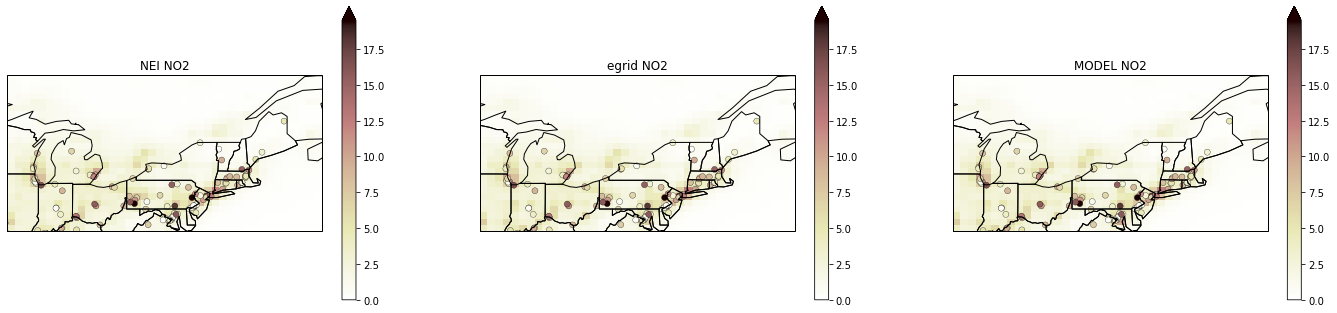

In [7]:
gridmod.obs_model_plot(ds = ds, df = EPA_obs_df, species = 'NO2',model_names = model_names,
               cmap = 'pink_r', figsize = [24,18],season = 'SON',
               vmin = levels_dict['PM25'].min(), vmax = levels_dict['PM25'].max(), 
               rows = 1, columns = 3, lat_lon = lat_lon_dict['NE_lat_lon'])

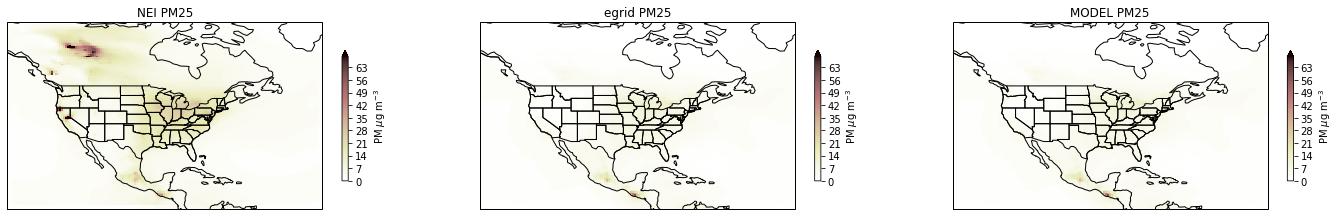

In [9]:
gridmod.concentration_plot(ds, species = 'PM25', model_names = model_names, season = 'SON',
                   rows = 1, columns = 3, lat_lon = lat_lon_dict['US_lat_lon'],
                    levels = levels_dict['O3'],figsize = [24,8])

#### max differences in PM in model and standard runs

## PROBLEM: WHY IS THE MODEL-NEI PM25 not working!!?

In [ ]:
print('max difference in PM model- egrid '+ str(ds['dif_MODEL-egrid_PM25'].max().values) + ' and min ' + str(ds['dif_MODEL-egrid_PM25'].min().values))
print('max difference in PM model- NEI '+ str(ds['dif_MODEL-NEI_PM25'].max().values) + ' and min ' + str(ds['dif_MODEL-NEI_PM25'].min().values))

print('max difference in O3 model- egrid '+ str(ds['dif_MODEL-egrid_O3'].max().values) + ' and min ' + str(ds['dif_MODEL-egrid_O3'].min().values))
print('max difference in O3 model- NEI '+ str(ds['dif_MODEL-NEI_O3'].max().values) + ' and min ' + str(ds['dif_MODEL-NEI_O3'].min().values))


# Stats on Observations vs. Models

## Interpolate data to get GC run data at observational points

In [170]:
#test

time = '2015-09-09'
model = 'MODEL'
species = 'PM25'

lats = np.array(ds['lat'] *np.pi / 180) # in radians
lons = np.array((360+ ds['lon'])*np.pi / 180) # in radians
data = ds[f'{model}_{species}'].sel(time = time).squeeze()

lats_new = EPA_obs_df.loc[EPA_obs_df['species'] == species_dict[species]]['Latitude'].unique()*np.pi / 180 # in radians
lons_new = (360+EPA_obs_df.loc[EPA_obs_df['species'] == species_dict[species]]['Longitude'].unique())*np.pi / 180 # in radians
interp_spline= RectBivariateSpline(lats, lons, data)
interp_data = interp_spline(lats_new,lons_new,grid = False)

In [129]:
for model in model_names:
    for species in list(species_dict.keys()):
        for time in ds['time'].values:
            #lat and lon in radians
            lats = np.array(ds['lat'] *np.pi / 180) # in radians
            lons = np.array((360+ ds['lon'])*np.pi / 180) # in radians
            #data selected for date
            data = ds[f'{model}_{species}'].sel(time = time).squeeze()
            
            #new lat and lon in radians
            lats_new = EPA_obs_df.loc[EPA_obs_df['species'] == species_dict[species]]['Latitude'].unique()*np.pi / 180 # in radians
            lons_new = (360+EPA_obs_df.loc[EPA_obs_df['species'] == species_dict[species]]['Longitude'].unique())*np.pi / 180 # in radians
            
            #interpolation function
            interp_spline= RectBivariateSpline(lats, lons, data)
            
            #interpolate and put into our EPA_obs_df
            EPA_obs_df[f'{modle}_interp_data'].loc[(EPA_obs_df['species'] == species_dict[species]) & (EPA_obs_df['date'] == time)] = interp_spline(lats_new,lons_new,grid = False)

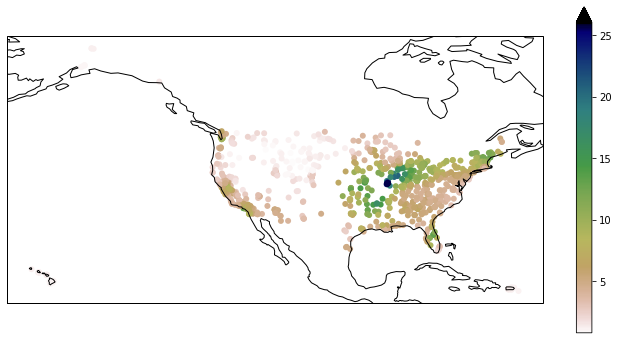

In [174]:
fig, ax = plt.subplots(figsize=[12,6])
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#adjust lon and lat:
lat=(lats_new*180 / np.pi)
lon=(lons_new*180 / np.pi - 360)
#define the concentrations
conc = interp_data
#colorbar parameters
PCM=ax.scatter(lon, lat,c=conc,transform=ccrs.PlateCarree(),
               cmap='gist_earth_r',edgecolors='none')
plt.colorbar(PCM, ax=ax,extend='max') 

In [ ]:
fig = plt.figure(figsize=[24,12])

for idx, s in enumerate(species_names): 
    ax = fig.add_subplot(3,4,idx+1)
    plt.subplots_adjust(hspace = .6)
    plt.plot(ds['time'],ds[f'{s}'].mean(dim=['lat','lon']),'o');
    plt.xlabel('Date')
    plt.ylabel(f'{s} Concentration');
    plt.xticks(rotation=45)
    plt.title(f'{s}')

In [ ]:
plt.plot(ds['time'],ds[f'NEI_NOx'].mean(dim=['lat','lon']),'ro')
spl = UnivariateSpline(Xnew,ds[f'NEI_NOx'].mean(dim=['lat','lon']), s = 0.1)
xs = np.linspace(Xnew.min(), Xnew.max(), 1000)
plt.plot(xs, spl(xs), 'g', lw=3)

In [ ]:
Xnew = matplotlib.dates.date2num(ds['time'])
